## Import Libraries
Libraries needed for importing, processing and visualising the datasets are imported here

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pathlib

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.4
numpy version: 1.19.5
seaborn version: 0.11.2
GPU present


2022-05-13 09:27:19.804288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 09:27:19.808338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 09:27:19.808445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Import Datasets
Datasets in the designated folders are imported as `pandas.DataFrame` objects.<br>
Dataset signal types and collection locations are automatically determined by their file names:
1. full path is read using `pathlib` libaray
2. using the naming format `<signal>_<location>_<increment>.csv`, the signal type and collection locations are extracted programmatically
3. all signals present are then encoded into a tag, with the signals sorted by alphanumeric order, in the format `{<signal> : <tag>}`, where `<tag>` is `0` to `n` number of signal types

In [2]:
# paths to load datasets from
train_store_path = '../datasets/sa/training'
val_store_path = '../datasets/sa/validation'

# convert to pathlib Path objects
train_dir = pathlib.Path(train_store_path)
val_dir = pathlib.Path(val_store_path)

# get list of datasets in dir
train_ds_paths = sorted(list(train_dir.glob('*.csv')))
val_ds_paths = sorted(list(val_dir.glob('*.csv')))

# extract classification target from file names
train_ds_type = np.array([x.parts[-1].split('_')[:2] for x in train_ds_paths])
val_ds_type = np.array([x.parts[-1].split('_')[:2] for x in val_ds_paths])

train_ds_order = [s.upper() for s in train_ds_type[:,0]]
val_ds_order = [s.upper() for s in val_ds_type[:,0]]

train_ds_loc = [s.upper() for s in train_ds_type[:, 1]]
val_ds_loc = [s.upper() for s in val_ds_type[:, 1]]

# generate signal type tags
signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in train_ds_order])))}
signal_names = list(signal_tags.keys())

Dataset importing process:
1. datasets are loaded using the `pandas.read_csv()` function into 2 different `DataFrame` objects, one containing dataset information and the other containing the data
    1. all necessary dataset information like `NumberSamples`, `NumberRecords`, and `SamplingFrequency` are present in the first 10 rows, as such the information object only reads the first 10 rows to save time
    2. the first 10 rows are subsequently skipped when importing the data
2. unnecessary information are dropped from both dataframes
    1. the dataset is separated into invididual records with these in between in the csv: `['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame']`. These are dropped to clean up the dataset.
    2. the information dataframe contains `['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame']`, which are unnecessary and are thus dropped.
3. All the processed dataframes are appended into corresponding `specs` and `datasets` lists, split by training and validation datasets

In [3]:
# load the dataset(s)

# load dataset information
specs = []
datasets = []

for dataset_paths in [train_ds_paths, val_ds_paths]:
    temp_ds = []
    temp_specs = []
    
    for path in dataset_paths:
        print(f'loading {path}...', end=' ')

        # load dataset details
        df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
        df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

        temp_specs.append(df_spec)

        # load data, strip unnecessary bits out
        df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
        df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
        df['I'] = df['I'].astype('float')

        print(f'loaded')

        temp_ds.append(df)
        
    datasets.append(temp_ds)
    specs.append(temp_specs)
    
print('done.')

loading ../datasets/sa/training/bnet_office_1.csv... loaded
loading ../datasets/sa/training/bnet_roof_1.csv... loaded
loading ../datasets/sa/training/bt_library_1.csv... loaded
loading ../datasets/sa/training/bt_office_1.csv... loaded
loading ../datasets/sa/training/bt_room_1.csv... loaded
loading ../datasets/sa/training/fm_roof_1.csv... loaded
loading ../datasets/sa/training/fnet_library_1.csv... loaded
loading ../datasets/sa/training/fnet_office_1.csv... loaded
loading ../datasets/sa/training/fnet_roof_1.csv... loaded
loading ../datasets/sa/training/fnet_room_1.csv... loaded
loading ../datasets/sa/training/lte_library_1.csv... loaded
loading ../datasets/sa/training/lte_library_2.csv... loaded
loading ../datasets/sa/training/lte_library_3.csv... loaded
loading ../datasets/sa/training/lte_office_1.csv... loaded
loading ../datasets/sa/training/lte_office_2.csv... loaded
loading ../datasets/sa/training/lte_room_1.csv... loaded
loading ../datasets/sa/training/lte_room_2.csv... loaded
load

## Data pre-processing
Pre-processing process:
1. desired record length is defined by `rlength`
2. iterate through list of dataframes, starting with training datasets
3. extract each record based on `NumberSamples` defined by dataset's corresponding information dataframe regardless of `rlength`
4. check if `NumberSamples` is longer or shorter than `rlength`
    1. if longer, truncate record to `rlength`
    2. if shorter, pad record to `rlength` with a random amount of padding on the left and right of the record
    3. else, do nothing and use record as-is
5. add record to `temp_processed` which is then added to `processed`, to ensure training and validation data are split up correctly
    1. all records follow the format `[<signal>, <tag>, <location>, <data>]`
6. records are merged into a training dataframes: `df_train` and `df_test` for training and validation data respectively
7. shuffle training and validation datasets to ensure training and minimise overfit

In [4]:
# split dataset(s) into records, extract test dataset
processed = []

# number of test records to extract
ntest = 100
rlength = 1024

for h in range(len(datasets)):
    temp_processed = []
    
    print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
    for i in range(len(datasets[h])):
        nrecords = specs[h][i].loc['NumberRecords']['info'] if not h else 400
        nsamples = specs[h][i].loc['NumberSamples']['info']
        ds_length = datasets[h][i].shape[0]
        
        # make life easier
        ds_order = train_ds_order if not h else val_ds_order
        ds_loc = train_ds_loc if not h else val_ds_loc

        # sanity check
        print(f'{ds_order[i]:<13}\t{ds_loc[i]:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

        # loop through dataset to split 
        for j in range(nrecords):
            # extract sample length worth of samples for each record, then transpose for easier access later
            record = datasets[h][i].iloc[(nsamples * j):(nsamples * (j+1))].values.T

            # pad shorter records with random padding to rlength
            if nsamples < rlength:
                # deterine pad amount
                pad_length = rlength - nsamples
                lpad_length = np.random.randint(0, pad_length+1)
                rpad_length = pad_length - lpad_length

                # generate pad
                lpad = np.zeros((2, lpad_length))
                rpad = np.zeros((2, rpad_length))

                # concatenate pad
                record = np.concatenate([lpad, record, rpad], axis=1)

            # truncate longer records to rlength
            elif nsamples > rlength:
                record = record[:,:rlength]

            # add processed record to list
            temp_processed.append([ds_order[i], signal_tags[ds_order[i]], ds_loc[i], record])
            
    processed.append(temp_processed)

# convert list into dataframes for later use, randomise, extract test records
df_train = pd.DataFrame(processed[0], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)
df_test = pd.DataFrame(processed[1], columns=['signal_type', 'tag', 'location', 'record']) #.sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Train\t{df_train.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')
print(f'Test\t{df_test.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')


Type		Location	Total Records	Samples/Record
BNET         	OFFICE         	12684  		1024   
BNET         	ROOF           	5743   		1024   
BT           	LIBRARY        	5869   		1024   
BT           	OFFICE         	23885  		1014   
BT           	ROOM           	9000   		1024   
FM           	ROOF           	5300   		1280   
FNET         	LIBRARY        	6343   		1024   
FNET         	OFFICE         	4500   		1024   
FNET         	ROOF           	3151   		1024   
FNET         	ROOM           	2450   		1024   
LTE          	LIBRARY        	1200   		1024   
LTE          	LIBRARY        	1450   		1024   
LTE          	LIBRARY        	1500   		1024   
LTE          	OFFICE         	3202   		1014   
LTE          	OFFICE         	3550   		1014   
LTE          	ROOM           	1850   		1024   
LTE          	ROOM           	1650   		1024   
LTE          	ROOM           	1300   		1024   
WIFI         	LIBRARY        	1250   		1024   
WIFI         	LIBRARY        	1200   		1024   
WIFI         	L

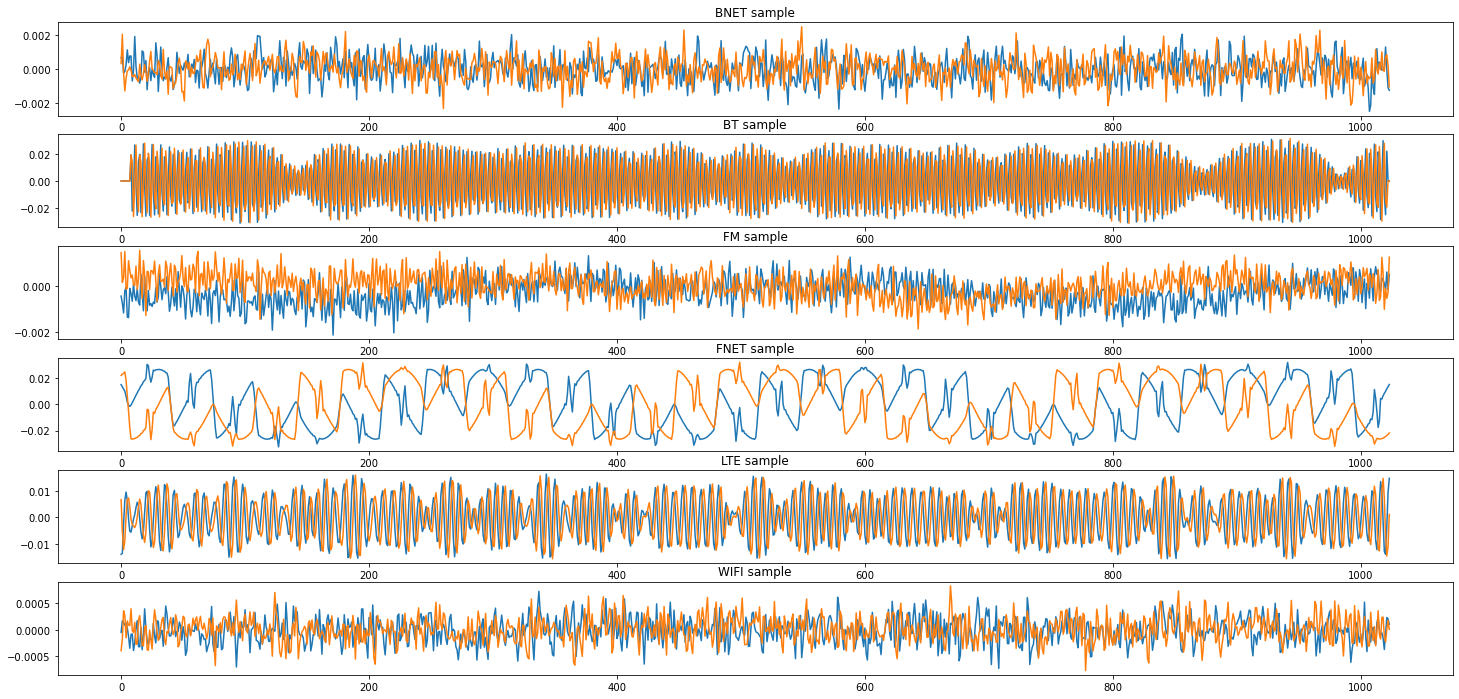

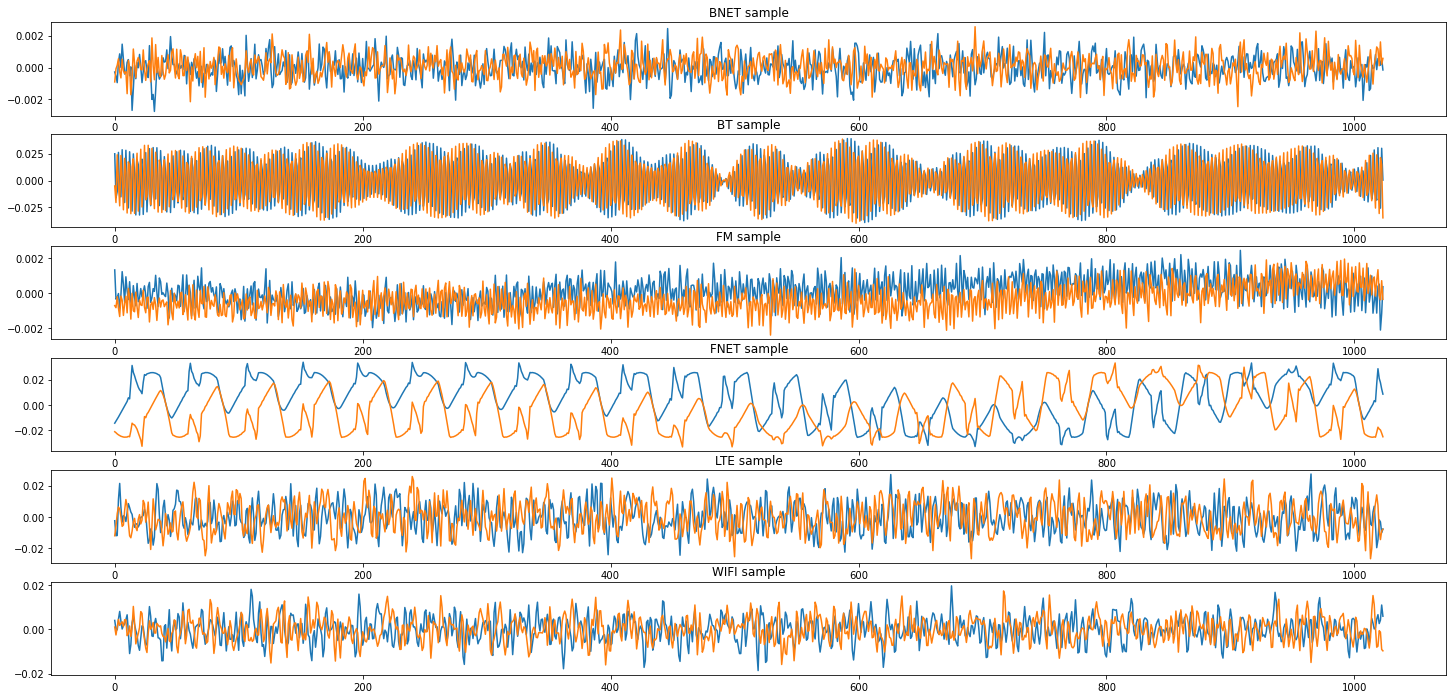

In [5]:
# plot some sample signals
fig1 = plt.figure(1, figsize=(25, 12))
fig2 = plt.figure(2, figsize=(25, 12))

for i, key in enumerate(list(signal_tags.keys())):
    # training data
    ip, qd = df_train[df_train['signal_type'] == key]['record'].sample().iloc[0]
    
    ax = fig1.add_subplot(6, 1, i+1)

    ax.plot(ip)
    ax.plot(qd)
    
    ax.set_title(f'{key} sample')
    
    # validation data
    ip, qd = df_test[df_test['signal_type'] == key]['record'].sample().iloc[0]
    
    ax = fig2.add_subplot(6, 1, i+1)

    ax.plot(ip)
    ax.plot(qd)
    
    ax.set_title(f'{key} sample')
    
plt.show()

In [6]:
# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        result = np.zeros(n_cat)
        result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

Due to how the model works, the data and its corresponding classification targets need to be processed as so:
1. data is reshaped from the format `[2, <record length>]` to `[2, <record length>, 1]`
2. classification targets are one-hot encoded using the above defined `one_hot` function
    1. it turns a numeric input into an array of mostly zeros with a single 1 in the input's number as the array position, e.g. 4 standing for Wifi into `[0, 0, 0, 0, 1]`

In [7]:
# remove some classes
drop_classes = ['LTE']

df_train = df_train.drop(df_train[df_train['signal_type'].isin(drop_classes)].index)

df_unknown = df_test[df_test['signal_type'].isin(drop_classes)]
df_test = df_test.drop(df_unknown.index)

# generate new tags for classification
train_tags = {k : i for i, k in enumerate(sorted(df_train['signal_type'].unique()))}
unknown_tags = {k : i for i, k in enumerate(sorted(df_unknown['signal_type'].unique()))}

df_train['tag'] = [train_tags[k] for k in df_train['signal_type']]
df_test['tag'] = [train_tags[k] for k in df_test['signal_type']]
df_unknown['tag'] = [unknown_tags[k] for k in df_unknown['signal_type']]

# extract train and test data
X_train = np.concatenate(df_train['record'].values).reshape((df_train.shape[0], 2, rlength, 1))
y_train = one_hot(df_train['tag'].values, len(train_tags))

X_test = np.concatenate(df_test['record'].values).reshape((df_test.shape[0], 2, rlength, 1))
y_test = one_hot(df_test['tag'].values, len(train_tags))

## Model construction and training
This particular model cannot be fully constructed using the Keras API due to the use of skip-connections, instead the Tensorflow Functional API is used.

In [8]:
# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Dense, Input, Flatten

In [9]:
# functions for model segments
def res_unit(x, dim, n):
    '''
    function that creates a residual unit for each residual stack.

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of layer
    n: number of units to create
    '''

    for _ in range(n):
        u = Conv2D(dim, 2, activation='relu', padding='same')(x)
        u = Conv2D(dim, 2, activation='linear', padding='same')(u)

        # skip-con
        x = concatenate([u, x])

    return x

def res_stack(x, dim):
    '''
    function that creates a residual stack for the model

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of stack
    '''

    s = Conv2D(dim, 1, activation='linear', padding='same')(x)
    s = res_unit(s, dim, 2)
    s = MaxPooling2D(2, padding='same')(s)

    return s

In [10]:
# function to create main model
def create_model(in_dim, out_dim):
    '''
    function to construct the actual resnet model.

    INPUT PARAMETERS
    in_dim: dimensions of input
    out_dim: size of output
    '''

    input_layer = Input(in_dim)
    
    # res stacks
    x = res_stack(input_layer, 512)
    x = res_stack(x, 256)
    x = res_stack(x, 128)
    x = res_stack(x, 64)
    x = res_stack(x, 32)
    x = res_stack(x, 16)

    # fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='selu')(x)
    x = Dense(128, activation='selu')(x)

    output_layer = Dense(out_dim, activation='softmax')(x)

    # turn layers into model
    model = Model(inputs=input_layer, outputs=output_layer, name='resnet_rf_classification_model')

    return model

2021-11-26 10:48:59.298440: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-26 10:48:59.298852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 10:48:59.299252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 10:48:59.299579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

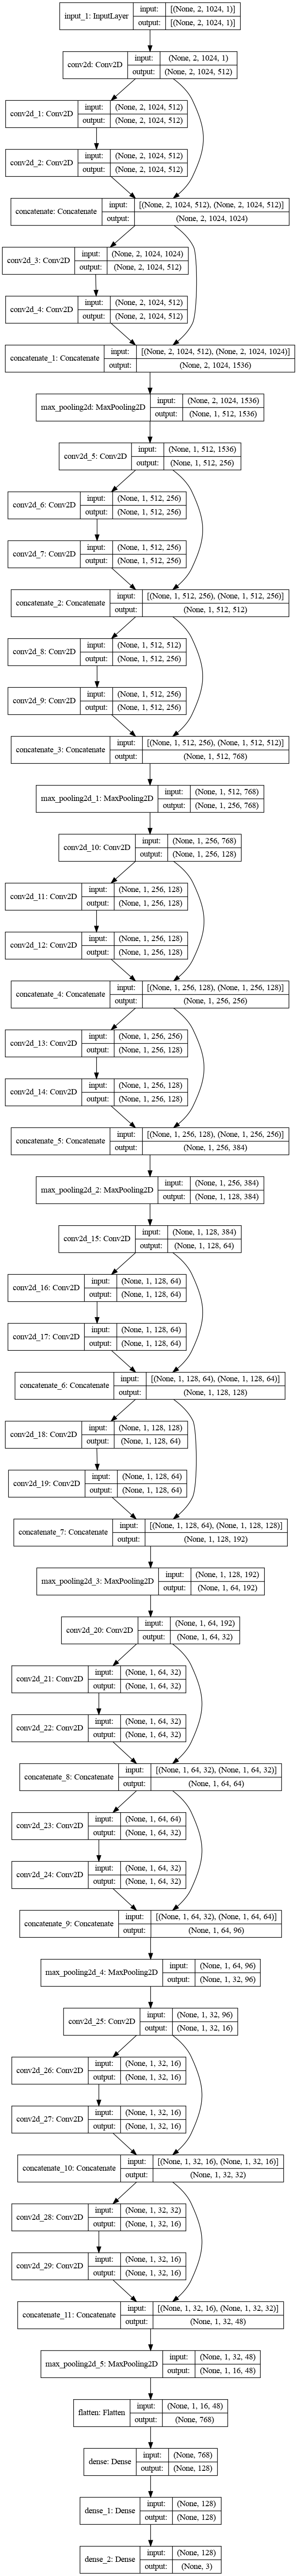

In [11]:
model = create_model((2, rlength, 1), len(train_tags))

tf.keras.utils.plot_model(model, show_shapes=True)

The model is trained here, with early stopping to minimise overfit.

In [12]:
# train model
# import metrics
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#early stopping
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[callback], validation_split=0.2)

2021-11-26 10:49:00.488175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-26 10:49:02.013744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-11-26 10:49:02.695514: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-26 10:49:02.695908: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-26 10:49:02.695924: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-11-26 10:49:02.696389: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-26 10:49:02.696463: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-11-26 10:49:07.498893: I tensorflow/stream_executor/cuda/c

1597/1597 [==============================] - 404s 247ms/step - loss: 0.1452 - accuracy: 0.9195 - val_loss: 0.0078 - val_accuracy: 0.9986
Epoch 2/50
1597/1597 [==============================] - 362s 226ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0024 - val_accuracy: 0.9991
Epoch 3/50
1597/1597 [==============================] - 362s 226ms/step - loss: 0.0158 - accuracy: 0.9946 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 4/50
1597/1597 [==============================] - 362s 227ms/step - loss: 0.0400 - accuracy: 0.9842 - val_loss: 0.0038 - val_accuracy: 0.9995
Epoch 5/50
1597/1597 [==============================] - 362s 227ms/step - loss: 0.0069 - accuracy: 0.9974 - val_loss: 0.0350 - val_accuracy: 0.9772
Epoch 6/50
1597/1597 [==============================] - 361s 226ms/step - loss: 0.0252 - accuracy: 0.9956 - val_loss: 0.2230 - val_accuracy: 0.9125
Epoch 7/50
1597/1597 [==============================] - 362s 227ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.002

## Model Evaluation

In [13]:
# evaluate model performance on standard dataset
results = model.evaluate(X_test, y_test)

print(f'loss: {results[0]:.3f} | accuracy: {results[1]:.3f}')

100/100 [==============================] - 7s 70ms/step - loss: 0.0084 - accuracy: 0.9978
loss: 0.008 | accuracy: 0.998


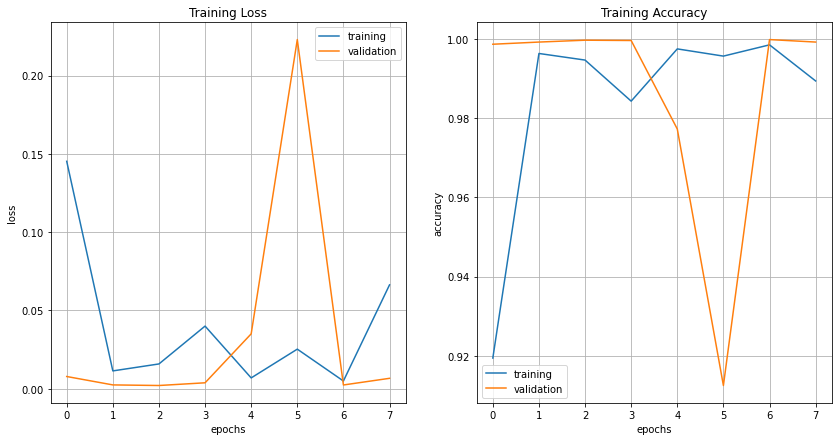

In [14]:
# plot out loss and accuracy graphs
train_hist = history.history

fig = plt.figure(1, figsize=(14, 7))

# loss graph
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_hist['loss'], label='training')
ax1.plot(train_hist['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(b=True)

# accuracy graph
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_hist['accuracy'], label='training')
ax2.plot(train_hist['val_accuracy'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(b=True)

plt.show()

In [15]:
# check what the model returns
X_preds = model.predict(X_test)

# process predictions
X_preds_processed = np.argmax(X_preds, axis=1)
y_preds = df_test['tag'].values

print(f'Incorrect Predictions')

ostr = f'Actual\t'
for k, v in train_tags.items():
    ostr += f'{k}\t'
print(ostr)

# print percentages for incorrect predictions
for i, pred in enumerate(X_preds_processed):
    percentages = X_preds[i]
    ostr = f'{list(train_tags.keys())[y_preds[i]]}\t'

    # generate string to output
    for p in percentages:
        ostr += f'{p:<7.3f}\t'

    print(ostr)
    
    if i >= 100:
        break
        
print(X_preds)

Incorrect Predictions
Actual	BT	FNET	WIFI	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.000  	0.000  	0.000  	
BT	1.

In [16]:
# check unknown signal performance
U_test = np.concatenate(df_unknown['record'].values).reshape((df_unknown.shape[0], 2, rlength, 1))[::-1]
# U_actual = one_hot(df_unknown['tag'].values, 2)

U_preds = model.predict(U_test)

# process predictions
U_preds_processed = np.argmax(U_preds, axis=1)
U_actual = df_unknown['tag'].values[::-1]

print(f'Unknown Predictions')

ostr = f'Actual\t'

# do sensitivity calibration for detectability


for k, v in train_tags.items():
    ostr += f'{k}\t'
print(ostr)

# print percentages for incorrect predictions
for i, pred in enumerate(U_preds_processed):
    percentages = U_preds[i]
    ostr = f'{list(unknown_tags.keys())[U_actual[i]]}\t'

    # generate string to output
    for p in percentages:
        ostr += f'{p:<7.3f}\t'

    print(ostr)
    
    if i >= 100:
        break
        

Unknown Predictions
Actual	BT	FNET	WIFI	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.001  	0.000  	0.999  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	1.000  	0.000  	0.000  	
LTE	0.000  	0.000  	1.000  	
LTE	1.000  	0.000  	0.000  	
LTE	1.000  	0.000  	0.000  	
LTE	1.000  	0.000  	0.000  	
LTE	0.007  	0.000  	0.993  	
LTE	1.000  	0.000  	0.000  	
LTE	0.001  	0.000  	0.999  	
LTE	0.000  	0.000  	1.000  	
LTE	0.124  	0.000  	0.876  	
LTE	0.000  	0.000  	1.000  	
LTE	1.000  	0.000  	0.000  	
LTE	0.999  	0.000  	0.001  	
LTE	0.001  	0.000  	0.999  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LTE	0.003  	0.000  	0.997  	
LTE	0.000  	0.000  	1.000  	
LTE	0.000  	0.000  	1.000  	
LT

In [17]:
df_unknown

,signal_type,tag,location,record
1200,FM,0,ROOF,"[[-0.00062134, 0.000179, 2.991e-05, -0.0011866..."
1201,FM,0,ROOF,"[[0.00090035, -0.00075924, -0.00084585, 0.0011..."
1202,FM,0,ROOF,"[[-0.00074433, -0.0002952, -3.205e-05, -0.0009..."
1203,FM,0,ROOF,"[[0.00068475, -6.876e-05, 0.00039385, -0.00017..."
1204,FM,0,ROOF,"[[-0.00051307, -0.00023337, -0.00087124, 3.392..."
...,...,...,...,...
3595,LTE,1,ROOM,"[[0.00873736, -0.0021106, -0.01220715, 0.00102..."
3596,LTE,1,ROOM,"[[0.00515525, -0.00051703, -0.01491251, -0.016..."
3597,LTE,1,ROOM,"[[-0.01326663, 0.00368938, 0.01217812, -0.0053..."
3598,LTE,1,ROOM,"[[0.01230402, 0.00617874, -0.00619331, -0.0067..."


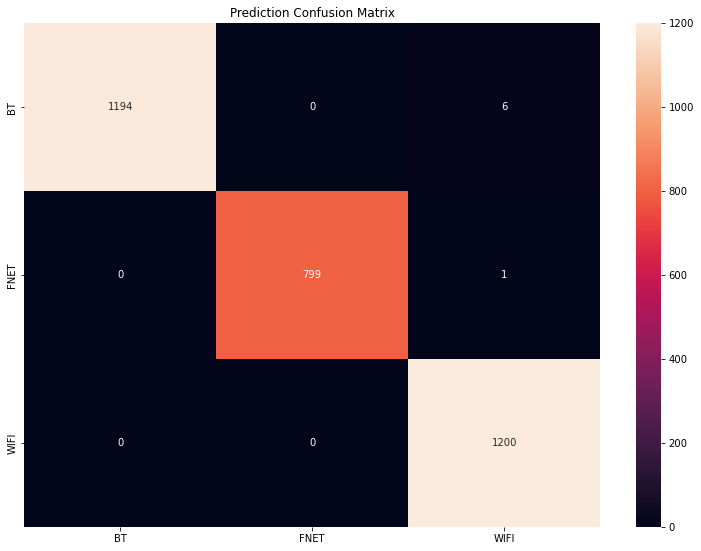

In [18]:
# plot confusion matrices
cm_pred = np.argmax(model.predict(X_test), axis=1)

cm_truth = df_test['tag'].values

# generate matrix
tags = list(train_tags.keys())
df_cm = pd.DataFrame(tf.math.confusion_matrix(cm_truth, cm_pred).numpy(), index=tags, columns=tags)

# plot matrix
fig = plt.figure(2, figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1])
sns.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title('Prediction Confusion Matrix')

plt.show()

In [19]:
# save model
model.save('../saved_models/SA_resnet_unknown_selu')

2021-11-26 13:08:59.629207: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../saved_models/SA_resnet_unknown_selu/assets


In [12]:
# convert model to tflite
import tensorflow as tf

# model = tf.keras.models.load_model('./saved_models/SA_resnet')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]
tflite_model = converter.convert()

# save model
with open('./saved_models/sa_resnet.tflite', 'wb') as f:
    f.write(tflite_model)
    
    f.close()

2021-11-12 16:37:20.718648: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpv4up5xct/assets


2021-11-12 16:37:22.398855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 16:37:22.399033: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-11-12 16:37:22.399110: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-11-12 16:37:22.399305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 16:37:22.399476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 16:37:22.399630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su